# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [2]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 1

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [3]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Data Preparation & Loader
# -----------------------------


# 1. Split Data (70% Train, 30% Validation)
# We convert to numpy first to use sklearn, then back to tensors later...
X_np = X_full.numpy()
y_np = y_full.numpy()

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_np, y_np, test_size=0.30, random_state=GROUP_NUMBER
)

# 2. Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)

# 3. Convert back to PyTorch Tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_raw, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val_raw, dtype=torch.float32)

print(f"Train Set: {X_train.shape}, Val Set: {X_val.shape}")

# Custom DataLoader Class
class KeplerDataLoader:
    def __init__(self, x, y, batch_size=64, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __iter__(self):
        n_samples = self.x.shape[0]
        indices = torch.arange(n_samples)
        if self.shuffle:
            indices = indices[torch.randperm(n_samples)]

        for start_idx in range(0, n_samples, self.batch_size):
            end_idx = min(start_idx + self.batch_size, n_samples)
            batch_idx = indices[start_idx:end_idx]
            yield self.x[batch_idx], self.y[batch_idx]

# Initialize Loaders
train_loader = KeplerDataLoader(X_train, y_train, batch_size=64, shuffle=True)
val_loader = KeplerDataLoader(X_val, y_val, batch_size=X_val.shape[0], shuffle=False)

Train Set: torch.Size([2100, 2]), Val Set: torch.Size([900, 2])


In [9]:
# 2. Neural Network Initialization
# ----------------------------------------------

torch.manual_seed(GROUP_NUMBER)

def init_weights(input_size, output_size):
    # 1. Creating raw data
    # Scaling by 0.1
    weights_data = torch.randn(input_size, output_size) * 0.1
    bias_data = torch.zeros(output_size)

    # 2. Convert to tensors
    w = weights_data.clone().detach().requires_grad_(True)
    b = bias_data.clone().detach().requires_grad_(True)

    return w, b

# Initialize Weights
w1, b1 = init_weights(2, 16)
w2, b2 = init_weights(16, 16)
w3, b3 = init_weights(16, 16)
w4, b4 = init_weights(16, 1)

print("Weights initialized correctly as Leaf Tensors.")

Weights initialized correctly as Leaf Tensors.


In [10]:
# 3. Helper Functions
# ---------------------
def sigmoid(z):
    return 1.0 / (1.0 + torch.exp(-z))

def relu(z):
    return torch.maximum(z, torch.tensor(0.0))

def manual_binary_cross_entropy(y_pred, y_true):
    """
    Implements: Loss = -1/N * sum( y*log(y_hat) + (1-y)*log(1-y_hat) )
    """
    epsilon = 1e-7
    y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon)

    loss = -torch.mean(
        y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred)
    )
    return loss

def get_predictions(y_prob):
    # Convert probabilities to binary class
    return (y_prob >= 0.5).float()

def calculate_accuracy(y_pred, y_true):
    correct = (y_pred == y_true).sum().item()
    return correct / y_true.size(0)

In [11]:
# 4. Training Loop (The Engine)
# ---------------------------------

learning_rate = 0.1
epochs = 500  # Kepler-186f simulation cycles

# Metric History for HUD
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

print("Initiating Exclusion Zone Protocol...")

for epoch in range(epochs):

    epoch_loss = 0
    epoch_acc = 0
    num_batches = 0

    # Training Phase...
    for batch_x, batch_y in train_loader:

        # 1. Forward Pass
        # Layer 1
        z1 = torch.matmul(batch_x, w1) + b1
        a1 = relu(z1)

        # Layer 2
        z2 = torch.matmul(a1, w2) + b2
        a2 = relu(z2)

        # Layer 3
        z3 = torch.matmul(a2, w3) + b3
        a3 = relu(z3)

        # Output Layer
        z4 = torch.matmul(a3, w4) + b4
        a4 = sigmoid(z4)

        # 2. Loss Calculation (Manual BCE)
        loss = manual_binary_cross_entropy(a4, batch_y)

        # 3. Backward Pass (Autograd computes dLoss/dw)
        loss.backward()

        # 4. Optimizer Step (Manual Gradient Descent)
        with torch.no_grad():
            w1 -= learning_rate * w1.grad
            b1 -= learning_rate * b1.grad
            w2 -= learning_rate * w2.grad
            b2 -= learning_rate * b2.grad
            w3 -= learning_rate * w3.grad
            b3 -= learning_rate * b3.grad
            w4 -= learning_rate * w4.grad
            b4 -= learning_rate * b4.grad

            # Zero gradients
            w1.grad.zero_()
            b1.grad.zero_()
            w2.grad.zero_()
            b2.grad.zero_()
            w3.grad.zero_()
            b3.grad.zero_()
            w4.grad.zero_()
            b4.grad.zero_()

        epoch_loss += loss.item()
        epoch_acc += calculate_accuracy(get_predictions(a4), batch_y)
        num_batches += 1

    # Store average training metrics
    train_loss_history.append(epoch_loss / num_batches)
    train_acc_history.append(epoch_acc / num_batches)

    # Validation Phase...
    with torch.no_grad():
        # Forward pass on full validation set
        vz1 = torch.matmul(X_val, w1) + b1
        va1 = relu(vz1)
        vz2 = torch.matmul(va1, w2) + b2
        va2 = relu(vz2)
        vz3 = torch.matmul(va2, w3) + b3
        va3 = relu(vz3)
        vz4 = torch.matmul(va3, w4) + b4
        va4 = sigmoid(vz4)

        v_loss = manual_binary_cross_entropy(va4, y_val)
        v_acc = calculate_accuracy(get_predictions(va4), y_val)

        val_loss_history.append(v_loss.item())
        val_acc_history.append(v_acc)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss_history[-1]:.4f} | Val Accuracy: {val_acc_history[-1]*100:.2f}%")

Initiating Exclusion Zone Protocol...
Epoch [50/500] | Train Loss: 0.6134 | Val Accuracy: 61.67%
Epoch [100/500] | Train Loss: 0.3068 | Val Accuracy: 89.33%
Epoch [150/500] | Train Loss: 0.2660 | Val Accuracy: 90.78%
Epoch [200/500] | Train Loss: 0.2518 | Val Accuracy: 90.00%
Epoch [250/500] | Train Loss: 0.2406 | Val Accuracy: 91.44%
Epoch [300/500] | Train Loss: 0.2511 | Val Accuracy: 91.44%
Epoch [350/500] | Train Loss: 0.2336 | Val Accuracy: 91.00%
Epoch [400/500] | Train Loss: 0.2378 | Val Accuracy: 91.56%
Epoch [450/500] | Train Loss: 0.2311 | Val Accuracy: 90.89%
Epoch [500/500] | Train Loss: 0.2250 | Val Accuracy: 91.11%


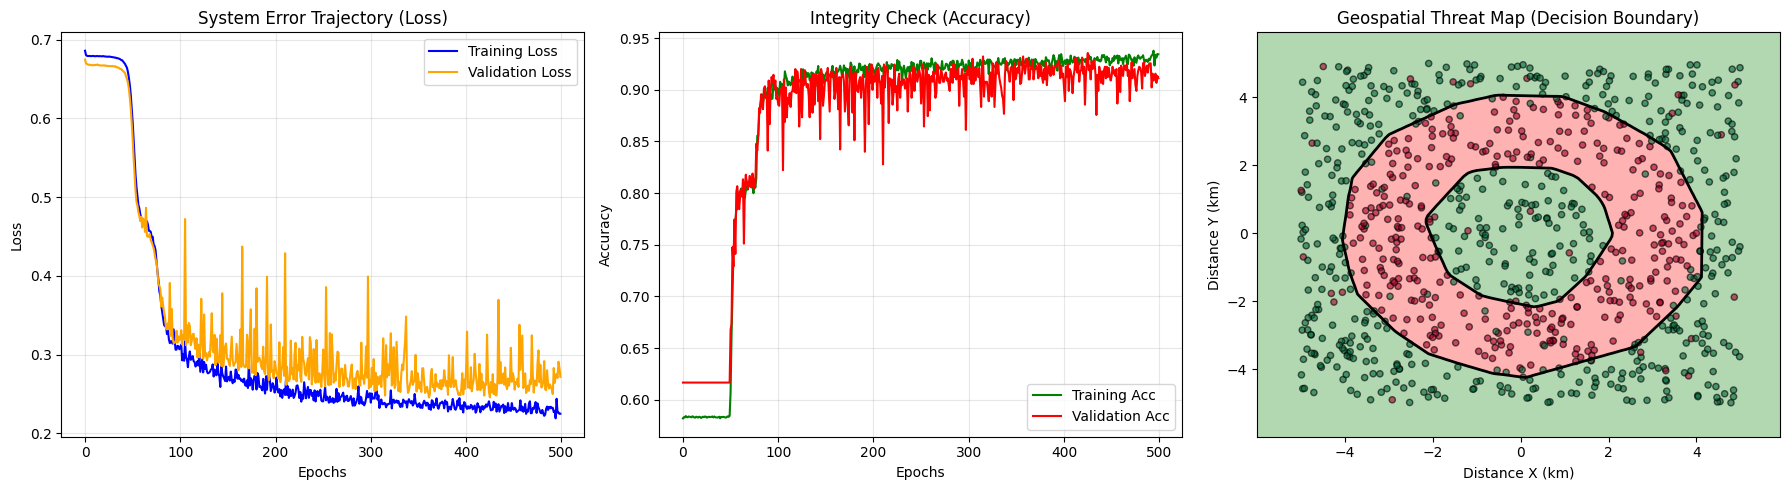

Final Validation Accuracy: 91.11%


In [12]:
# 5. GDC Dashboard
# -------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: System Error Trajectory (Loss)
axes[0].plot(train_loss_history, label='Training Loss', color='blue')
axes[0].plot(val_loss_history, label='Validation Loss', color='orange')
axes[0].set_title('System Error Trajectory (Loss)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel 2: Integrity Check (Accuracy)
axes[1].plot(train_acc_history, label='Training Acc', color='green')
axes[1].plot(val_acc_history, label='Validation Acc', color='red')
axes[1].set_title('Integrity Check (Accuracy)')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Panel 3: Geospatial Threat Map (Decision Boundary)
# Create a meshgrid to map the entire area
x_min, x_max = X_val_raw[:, 0].min() - 1, X_val_raw[:, 0].max() + 1
y_min, y_max = X_val_raw[:, 1].min() - 1, X_val_raw[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Flatten and scale the meshgrid points
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(scaler.transform(grid_points), dtype=torch.float32)

# Predict on the grid
with torch.no_grad():
    gz1 = torch.matmul(grid_tensor, w1) + b1
    ga1 = relu(gz1)
    gz2 = torch.matmul(ga1, w2) + b2
    ga2 = relu(gz2)
    gz3 = torch.matmul(ga2, w3) + b3
    ga3 = relu(gz3)
    gz4 = torch.matmul(ga3, w4) + b4
    ga4 = sigmoid(gz4)
    Z = ga4.reshape(xx.shape).numpy()

# Plot
axes[2].contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, colors=['green', 'red'])
axes[2].contour(xx, yy, Z, levels=[0.5], linewidths=2, colors='black') # Boundary line
axes[2].scatter(X_val_raw[:, 0], X_val_raw[:, 1], c=y_val_raw.ravel(),
                cmap='RdYlGn_r', edgecolors='k', s=20, alpha=0.6)
axes[2].set_title('Geospatial Threat Map (Decision Boundary)')
axes[2].set_xlabel('Distance X (km)')
axes[2].set_ylabel('Distance Y (km)')

plt.tight_layout()
plt.show()

print(f"Final Validation Accuracy: {val_acc_history[-1]*100:.2f}%")